# 11_2_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/11_2_LEARN_DataAnalysisML.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [ ]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 1. Setup H2O AutoML

In [ ]:
%%capture 
!pip install h2o

In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,6 hours 13 mins
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,5 months and 6 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_2gyzs4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,909 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
#h2o.shutdown()

### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [ ]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
first_input_for_ml 

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_C01,1,2,5,9,0.536658
2,yp49_D01,2,4,7,3,0.175896
3,yp49_E01,2,1,5,7,0.345201
4,yp49_F01,3,3,6,1,26.416324
...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000
163,yp51_D12,8,2,7,6,0.614962
164,yp51_E12,8,1,6,10,0.466688
165,yp50_F05,6,1,8,2,15.155009


### 1.2 Investigate how the predictions from the previous ML cycle mathced the sampled strains 

In [ ]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml = second_input_for_ml[['Line_name', '0','1','2','3','norm_strict_%']]
second_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

In [ ]:
list_of_promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]

pg8h_list_of_index = ['CYC1', 'ENO2']
pcpr_list_of_index = ['CCW12', 'TPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_input_for_ml['G8H'] = g8h_genotype
second_input_for_ml['CPR'] = cpr_genotype
second_input_for_ml['pG8H'] = pg8h_genotype
second_input_for_ml['pCPR'] = pcpr_genotype
second_input_for_ml

,Line_name,0,1,2,3,Amt_norm,G8H,CPR,pG8H,pCPR
0,yp53_A01,4,1,5,2,9.058562,Vmin,Aan,CYC1,CCW12
1,yp53_A02,4,1,5,2,28.175952,Vmin,Aan,CYC1,CCW12
2,yp53_A04,4,2,5,2,80.375862,Vmin,Aan,ENO2,CCW12
3,yp53_A06,5,1,5,2,121.767572,Smus,Aan,CYC1,CCW12
4,yp53_A07,5,2,6,2,159.059724,Smus,Aan,ENO2,TPI1
...,...,...,...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951,Vmin,Cro,CYC1,TPI1
125,yp54_C04,5,2,6,3,94.318358,Smus,Ara,ENO2,TPI1
126,yp54_C09,3,1,6,3,46.469517,Cro,Ara,CYC1,TPI1
127,yp54_D12,5,1,6,6,3.718051,Smus,Ahu,CYC1,TPI1


In [ ]:
second_input_for_ml["Names"] = second_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
second_input_for_ml =second_input_for_ml[['Names', 'Amt_norm', 'Line_name']]
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [ ]:
first_round_top_producers = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_first_DBTL_1st_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='Predicted_strict_production', ascending=False)

first_round_top_producers["Names"] = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
first_round_top_producers  = first_round_top_producers[['Names', 'Predicted_strict_production']]
first_round_top_producers['Predicted_strict_production_rank_pct']= first_round_top_producers['Predicted_strict_production'].rank(pct=True)
first_round_top_producers

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct
0,Smus-ENO2-TPI1-Rse,169.288180,1.000000
1,Rsep-ENO2-TPI1-Ara,162.151856,0.999106
2,Smus-ENO2-CCW12-Ara,161.904255,0.998213
3,Smus-CYC1-TPI1-Ara,157.638727,0.997319
4,Smus-ENO2-TPI1-Aan,156.976470,0.996425
...,...,...,...
1114,Rsep-CYC1-TPI1-Ani,-9.125477,0.004468
1115,Ccal-ENO2-TPI1-Cac,-12.768510,0.003575
1116,Rsep-PCK1-CCW12-Ara,-12.901417,0.002681
1117,Ccal-ENO2-CCW12-Cac,-16.241411,0.001787


In [ ]:
second_input_for_ml

,Names,Amt_norm,Line_name
0,Vmin-CYC1-CCW12-Aan,9.058562,yp53_A01
1,Vmin-CYC1-CCW12-Aan,28.175952,yp53_A02
2,Vmin-ENO2-CCW12-Aan,80.375862,yp53_A04
3,Smus-CYC1-CCW12-Aan,121.767572,yp53_A06
4,Smus-ENO2-TPI1-Aan,159.059724,yp53_A07
...,...,...,...
124,Vmin-CYC1-TPI1-Cro,15.322951,yp54_A04
125,Smus-ENO2-TPI1-Ara,94.318358,yp54_C04
126,Cro-CYC1-TPI1-Ara,46.469517,yp54_C09
127,Smus-CYC1-TPI1-Ahu,3.718051,yp54_D12


In [ ]:
## merging the unsampled library with the second sampling
predicted_vs_sampled = pd.merge(first_round_top_producers, second_input_for_ml, on=['Names'])
predicted_vs_sampled['norm_strict_measured_rank'] = predicted_vs_sampled['Amt_norm'].rank(pct=True)
predicted_vs_sampled['Predicted_strict_production_rank_pct'] = predicted_vs_sampled['Predicted_strict_production'].rank(pct=True)


#new_input_for_ml['NA_bottom'] = new_input_for_ml['Amt_norm'].rank(na_option='bottom')
#new_input_for_ml['pct_rank'] = new_input_for_ml['Amt_norm'].rank(pct=True)
predicted_vs_sampled = predicted_vs_sampled.sort_values(by= 'Amt_norm', ascending = False)


In [ ]:
predicted_vs_sampled

,Names,Predicted_strict_production,Predicted_strict_production_rank_pct,Amt_norm,Line_name,norm_strict_measured_rank
0,Smus-ENO2-TPI1-Rse,169.288180,0.995575,169.631396,yp53_D09,1.000000
10,Rsep-ENO2-TPI1-Clo,103.496648,0.907080,159.517718,yp53_C06,0.991150
4,Smus-ENO2-TPI1-Aan,156.976470,0.964602,159.059724,yp53_A07,0.982301
31,Smus-CYC1-CCW12-Clo,57.162466,0.725664,143.483630,yp53_C01,0.973451
32,Cro-ENO2-TPI1-Cro,56.438602,0.712389,138.267757,yp54_B01,0.964602
...,...,...,...,...,...,...
99,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D10,0.061947
98,Smus-CYC1-TPI1-Ahu,2.649671,0.123894,0.000000,yp54_D09,0.061947
97,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G04,0.061947
96,Cro-CYC1-CCW12-Ani,2.686140,0.146018,0.000000,yp53_G03,0.061947


In [ ]:
from constrain.plotting.plotting import correlation_plot

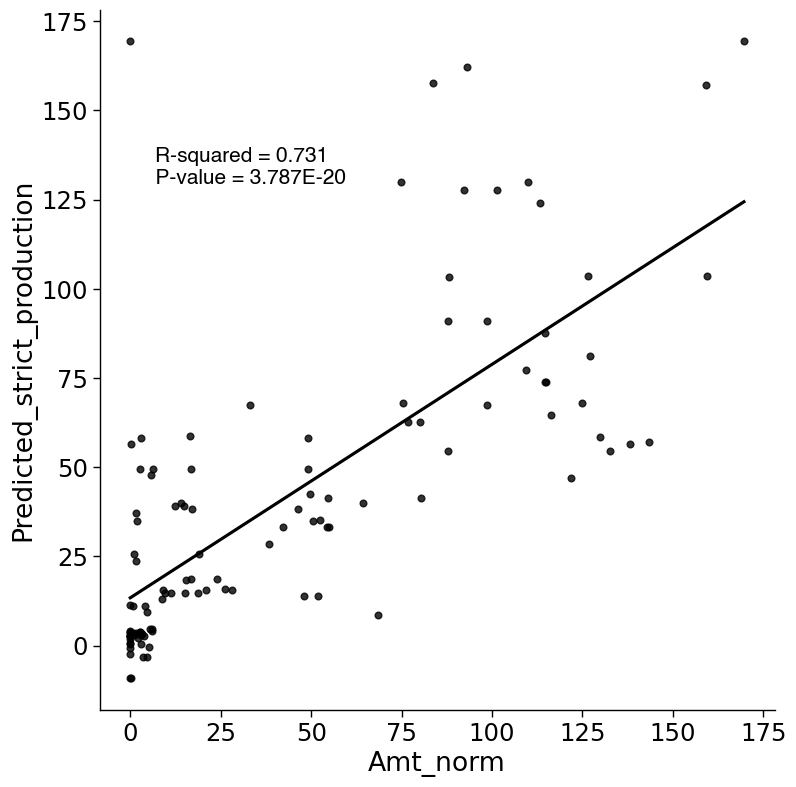

In [ ]:
correlation_plot(predicted_vs_sampled,"Amt_norm","Predicted_strict_production")

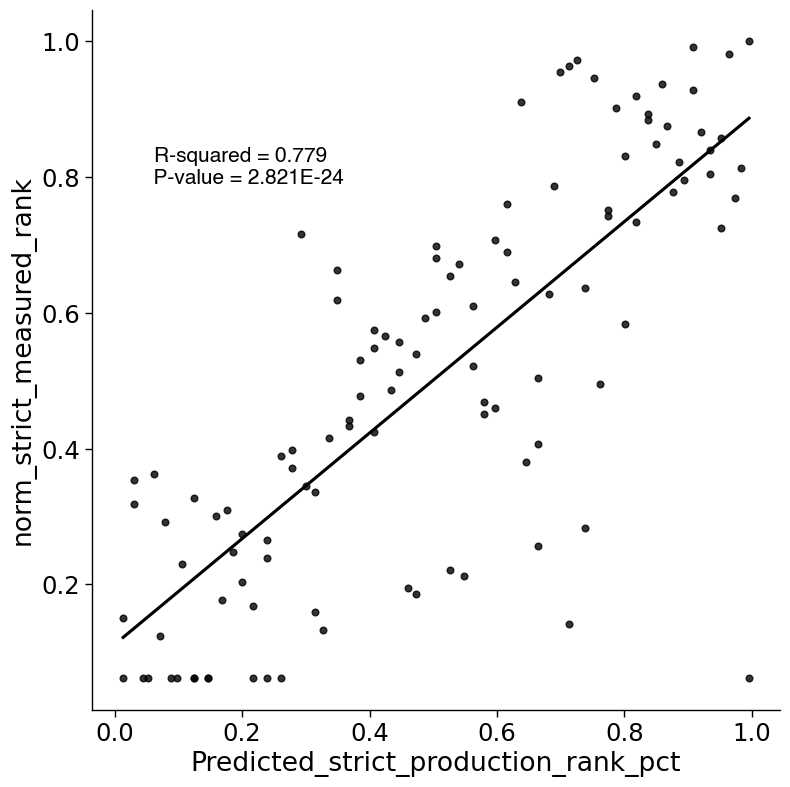

In [ ]:
correlation_plot(predicted_vs_sampled,"Predicted_strict_production_rank_pct","norm_strict_measured_rank")

### 1.3 Merging the dataframes for updating the model 

In [ ]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

In [ ]:
new_input_for_ml = pd.concat([first_input_for_ml,second_input_for_ml ])
new_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']

new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_C01,1,2,5,9,0.536658
2,yp49_D01,2,4,7,3,0.175896
3,yp49_E01,2,1,5,7,0.345201
4,yp49_F01,3,3,6,1,26.416324
...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951
125,yp54_C04,5,2,6,3,94.318358
126,yp54_C09,3,1,6,3,46.469517
127,yp54_D12,5,1,6,6,3.718051


### 1.2 Update dataframe Change 

In [ ]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:296
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.773648648648647,2.1452702702702697,6.135135135135138,4.750000000000003,29.09914171700607
maxs,NaN,8.0,4.0,8.0,10.0,277.3078163064027
sigma,NaN,1.946604570553522,1.115003045338059,1.0554051268004114,2.5930153901508803,46.17102137141943
zeros,0,0,0,0,0,72
missing,0,0,0,0,0,0
0,yp49_A01,1.0,2.0,5.0,1.0,0.972700677969159
1,yp49_C01,1.0,2.0,5.0,9.0,0.5366584806139938
2,yp49_D01,2.0,4.0,7.0,3.0,0.1758959746019849


In [ ]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [ ]:
df_test.describe()

Rows:296
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,29.09914171700607
maxs,NaN,,,,,277.3078163064027
sigma,NaN,,,,,46.17102137141943
zeros,0,,,,,72
missing,0,0,0,0,0,0
0,yp49_A01,1,2,5,1,0.972700677969159
1,yp49_C01,1,2,5,9,0.5366584806139938
2,yp49_D01,2,4,7,3,0.1758959746019849


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## 2 RUN automl

Here we are defining the autoML object and after we can train it

In [ ]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    sort_metric = "MAE",
    keep_cross_validation_predictions=True 
)

Train a model based on the target and the df. 

In [94]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 )


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 25.9 s, sys: 5.17 s, total: 31.1 s
Wall time: 1h 7s
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_6_AutoML_11_20221215_152128

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 370.3638888267753
RMSE: 19.24484057680851
MAE: 8.476364547882579
RMSLE: NaN
R^2: 0.825675123887031
Mean Residual Deviance: 370.3638888267753
Null degrees of freedom: 295
Residual degrees of freedom: 293
Null deviance: 628870.1505898823
Residual deviance: 109627.71109272548
AIC: 2598.699469329867

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 598.6751341028652
RMSE: 24.467838770575245
MAE: 12.422325204208265
RMSLE: NaN
R^2: 0.7182123534910563
Mean Residual Deviance: 598.6751341028652
Null degrees of freedom: 295
Residual degrees of freedom: 293

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,12.492460,2.887633,14.773646,13.767424,13.615550,15.105212,15.534618,10.486104,7.643333,12.244506,13.881619,7.872592
1,mean_residual_deviance,532.578300,298.970250,751.063960,1166.628300,648.224400,747.878230,432.898040,346.526120,206.632550,405.043800,431.317500,189.570420
2,mse,532.578300,298.970250,751.063960,1166.628300,648.224400,747.878230,432.898040,346.526120,206.632550,405.043800,431.317500,189.570420
3,null_deviance,63298.690000,37193.880000,87567.180000,143498.970000,54159.250000,104537.734000,34962.840000,50971.590000,39606.710000,41039.766000,52211.190000,24431.652000
4,r2,0.726944,0.102346,0.706769,0.642283,0.700433,0.795671,0.517402,0.830781,0.879041,0.686197,0.746388,0.764480
5,residual_deviance,17054.111000,13643.364000,25536.174000,51331.650000,16205.610000,19444.834000,14718.533000,8316.627000,4752.549000,12556.357000,12939.525000,4739.260700
6,rmse,22.282757,6.329564,27.405546,34.155940,25.460250,27.347363,20.806202,18.615211,14.374719,20.125700,20.768185,13.768457
7,rmsle,1.169125,0.166386,NaN,1.148565,1.165870,NaN,1.482468,NaN,NaN,1.161522,1.029981,1.026347


In [95]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model


In [96]:
# saving the models
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])

out_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

for m_id in model_ids:
     mdl = h2o.get_model(m_id)
     h2o.save_model(model=mdl, path=out_path, force=True)


In [97]:
len(model_ids)

490

Now we want to extract the best models

In [98]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

,model_id,mae,rmse,mse,rmsle,mean_residual_deviance
0,StackedEnsemble_BestOfFamily_6_AutoML_11_20221215_152128,12.422325,24.467839,598.675134,NaN,598.675134
1,XGBoost_lr_search_selection_AutoML_11_20221215_152128_select_grid_...,12.522050,24.884938,619.260155,NaN,619.260155
2,XGBoost_grid_1_AutoML_11_20221215_152128_model_165,12.727607,25.350302,642.637824,NaN,642.637824
3,StackedEnsemble_BestOfFamily_4_AutoML_11_20221215_152128,12.738069,24.801321,615.105522,NaN,615.105522
4,XGBoost_grid_1_AutoML_11_20221215_152128_model_131,13.055608,25.185519,634.310362,NaN,634.310362
...,...,...,...,...,...,...
485,GBM_grid_1_AutoML_11_20221215_152128_model_48,29.081092,40.334852,1626.900306,NaN,1626.900306
486,GBM_grid_1_AutoML_11_20221215_152128_model_6,29.143423,40.184123,1614.763734,NaN,1614.763734
487,GBM_grid_1_AutoML_11_20221215_152128_model_14,29.301669,40.992241,1680.363816,NaN,1680.363816
488,GBM_grid_1_AutoML_11_20221215_152128_model_27,29.516332,40.678130,1654.710260,NaN,1654.710260


### 3.1 Saving the best model

In [132]:
best_model = AutoML.get_best_model()
best_model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_6_AutoML_11_20221215_152128

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 370.3638888267753
RMSE: 19.24484057680851
MAE: 8.476364547882579
RMSLE: NaN
R^2: 0.825675123887031
Mean Residual Deviance: 370.3638888267753
Null degrees of freedom: 295
Residual degrees of freedom: 293
Null deviance: 628870.1505898823
Residual deviance: 109627.71109272548
AIC: 2598.699469329867

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 598.6751341028652
RMSE: 24.467838770575245
MAE: 12.422325204208265
RMSLE: NaN
R^2: 0.7182123534910563
Mean Residual Deviance: 598.6751341028652
Null degrees of freedom: 295
Residual degrees of freedom: 293
Null deviance: 632986.8953768252
Residual deviance: 177207.8396944481
AIC: 2740.848466417012

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,12.492460,2.887633,14.773646,13.767424,13.615550,15.105212,15.534618,10.486104,7.643333,12.244506,13.881619,7.872592
1,mean_residual_deviance,532.578300,298.970250,751.063960,1166.628300,648.224400,747.878230,432.898040,346.526120,206.632550,405.043800,431.317500,189.570420
2,mse,532.578300,298.970250,751.063960,1166.628300,648.224400,747.878230,432.898040,346.526120,206.632550,405.043800,431.317500,189.570420
3,null_deviance,63298.690000,37193.880000,87567.180000,143498.970000,54159.250000,104537.734000,34962.840000,50971.590000,39606.710000,41039.766000,52211.190000,24431.652000
4,r2,0.726944,0.102346,0.706769,0.642283,0.700433,0.795671,0.517402,0.830781,0.879041,0.686197,0.746388,0.764480
5,residual_deviance,17054.111000,13643.364000,25536.174000,51331.650000,16205.610000,19444.834000,14718.533000,8316.627000,4752.549000,12556.357000,12939.525000,4739.260700
6,rmse,22.282757,6.329564,27.405546,34.155940,25.460250,27.347363,20.806202,18.615211,14.374719,20.125700,20.768185,13.768457
7,rmsle,1.169125,0.166386,NaN,1.148565,1.165870,NaN,1.482468,NaN,NaN,1.161522,1.029981,1.026347


In [133]:
model_path = h2o.save_model(model=best_model, path="ConStrain_on_google_colab/Data/processed/ML_models_second_lib", force=True)

### 3.2 Exporting the leaderboard

In [119]:
# saving the leaderboard
import os
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


### 3.3 Importing the leaderboard

In [120]:
models_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_6_AutoML_11_20221215_152128,12.4223,24.4678,598.675,nan,598.675
XGBoost_lr_search_selection_AutoML_11_20221215_152128_select_grid_model_3,12.5221,24.8849,619.26,nan,619.26
XGBoost_grid_1_AutoML_11_20221215_152128_model_165,12.7276,25.3503,642.638,nan,642.638
StackedEnsemble_BestOfFamily_4_AutoML_11_20221215_152128,12.7381,24.8013,615.106,nan,615.106
XGBoost_grid_1_AutoML_11_20221215_152128_model_131,13.0556,25.1855,634.31,nan,634.31
DeepLearning_grid_1_AutoML_11_20221215_152128_model_13,13.1099,24.6693,608.574,nan,608.574
StackedEnsemble_AllModels_5_AutoML_11_20221215_152128,13.3768,25.5492,652.76,0.971288,652.76
XGBoost_grid_1_AutoML_11_20221215_152128_model_178,13.817,25.3518,642.713,nan,642.713
DeepLearning_grid_3_AutoML_11_20221215_152128_model_1,13.8416,25.1286,631.447,nan,631.447
XGBoost_grid_1_AutoML_11_20221215_152128_model_77,13.8751,25.6605,658.461,nan,658.461


## 4. Importing the best model

In [136]:
best_model = h2o.load_model("ConStrain_on_google_colab/Data/processed/ML_models_second_lib/"+lb[0,0])
my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/Data/processed/ML_models")
uploaded_model = h2o.upload_model(my_local_model)


In [137]:
cv = best_model.cross_validation_holdout_predictions()
type(cv)

NoneType

### 4.1 Investigate model

In [138]:
best_model.cross_validation_holdout_predictions()

Get the cross validation predictions

In [139]:
# This is where list of cv preds are stored (one element per fold):
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()
print(cross_validation_holdout_predictions)
print(len(cross_validation_holdout_predictions))

None


TypeError: object of type 'NoneType' has no len()

In [ ]:
cv_fram = cross_validation_holdout_predictions.as_data_frame()
cv_fram

In [ ]:
# However you most likely want a single-column frame including all cv preds
cross_validation_predictions = best_model.cross_validation_predictions()
print(len(cross_validation_predictions))

10


In [ ]:
as_data_frame_df_test = df_test.as_data_frame()
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()

In [ ]:
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
df3 = df3.reset_index()
df3['ranked_pct'] = df3['Amt_norm'].rank(pct= True)
df3['ranked_pct_predicted'] = df3['predict'].rank(pct= True)
df3

,index,Line_name,0,1,2,3,Amt_norm,predict,ranked_pct,ranked_pct_predicted
0,73,yp50_D03,5,2,6,3,277.307816,96.999344,1.000000,0.918919
1,75,yp50_G03,6,2,6,5,176.917201,111.369507,0.996622,0.969595
2,205,yp53_D09,5,2,6,5,169.631396,100.853073,0.993243,0.939189
3,86,yp50_E05,5,1,6,8,163.352037,75.240669,0.989865,0.814189
4,193,yp53_C06,6,2,6,4,159.517718,114.271469,0.986486,0.976351
...,...,...,...,...,...,...,...,...,...,...
291,92,yp50_G06,6,4,6,6,0.000000,0.126829,0.123311,0.131757
292,95,yp50_B07,4,3,8,7,0.000000,0.541050,0.123311,0.263514
293,99,yp50_G07,6,1,5,7,0.000000,1.518117,0.123311,0.381757
294,101,yp50_B08,4,4,5,7,0.000000,0.131664,0.123311,0.138514


In [140]:
len(df3)

NameError: name 'df3' is not defined

In [141]:
from constrain.plotting.plotting import bar_plot_w_hue

ImportError: cannot import name 'bar_plot_w_hue' from 'constrain.plotting.plotting' (/Users/lucaslevassor/projects/ConStrain/constrain/plotting/plotting.py)

In [142]:
%%capture
# initialize
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']
ds2 = df3[['Line_name', 'predict']]
ds2.columns = ['Line_name', 'strict']

# add category
ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

NameError: name 'df3' is not defined

In [ ]:
bar_plot_w_hue(dss, 'Line_name', 'strict', path = 'ConStrain_on_google_colab/Data/Plots_for_publication/11_2_LEARN_DataAnalysis/Prediction of the sampled library_ranked')

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_5141/4051055021.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds2['category'] = 'Predicted'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_5141/4051055021.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1['category'] = 'Strictosidine'


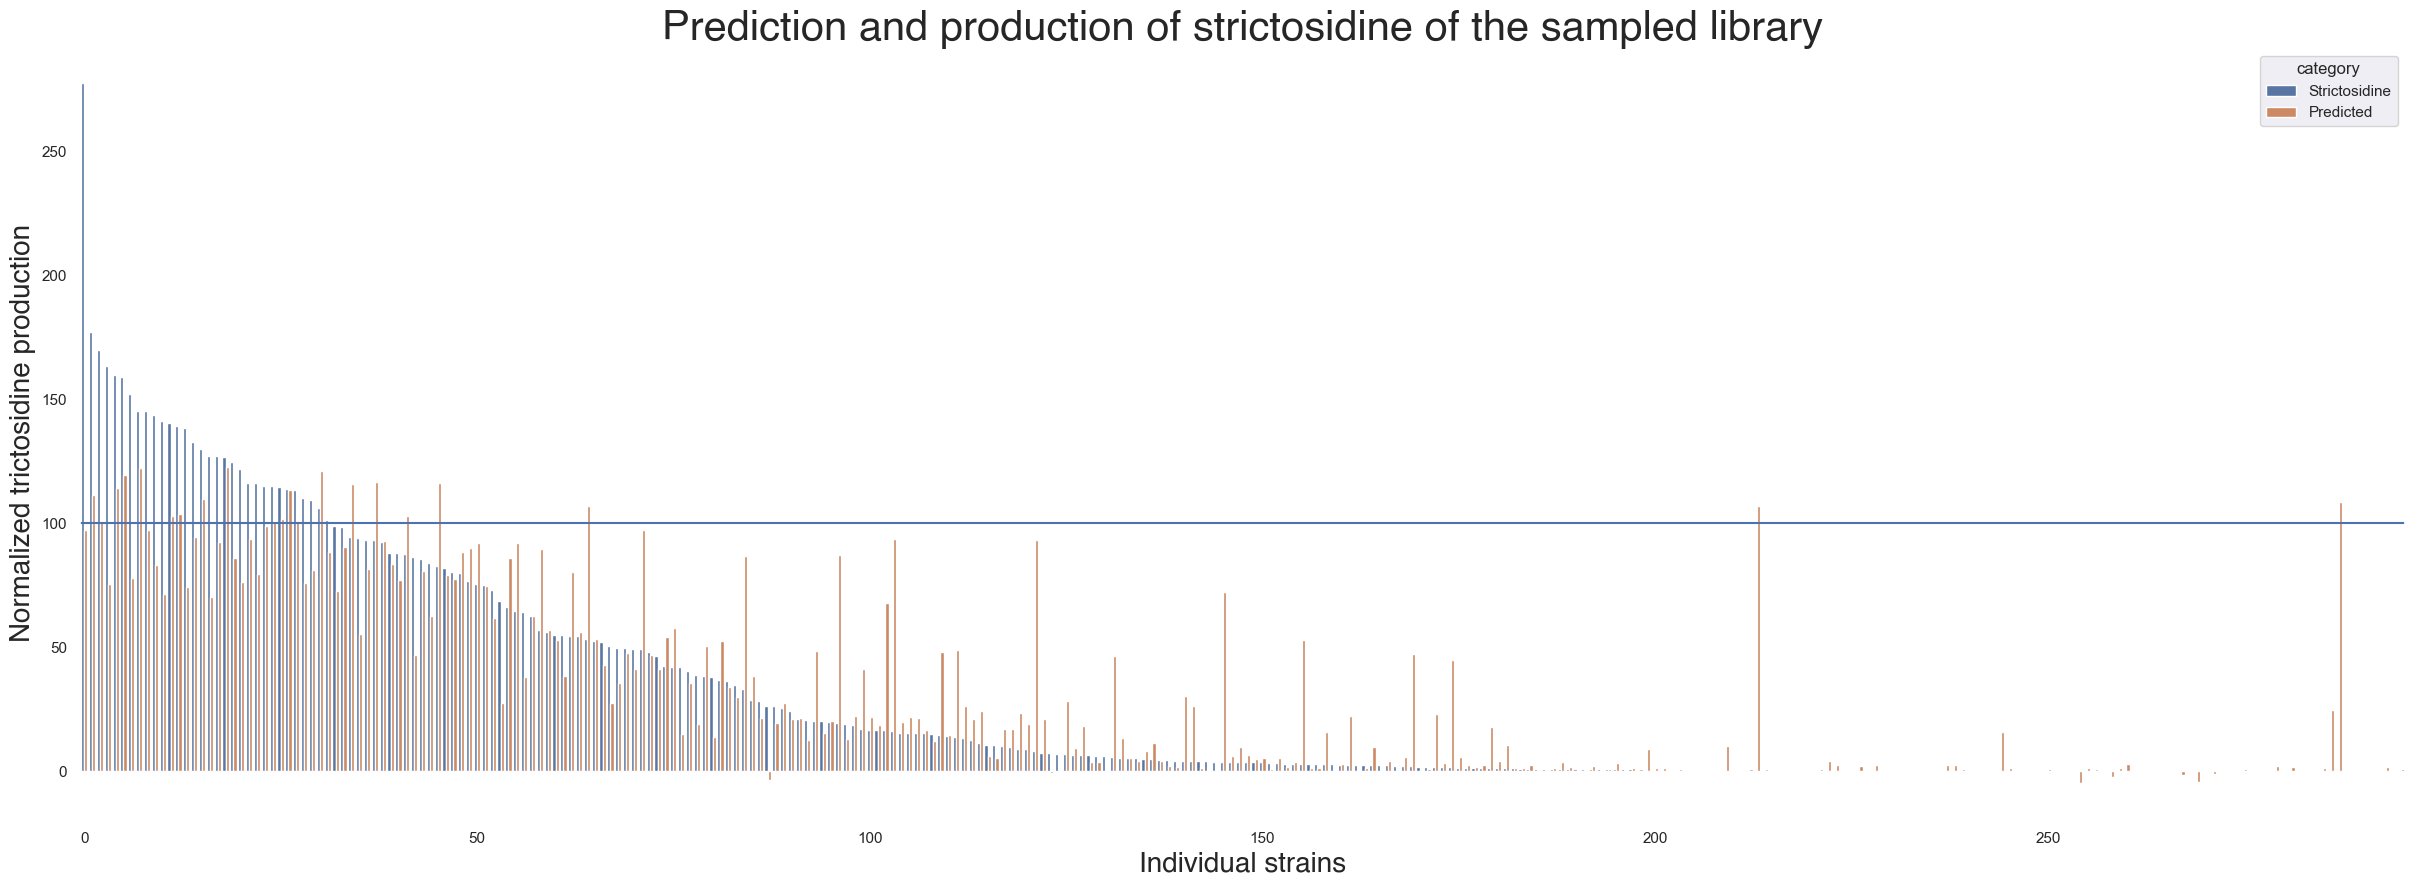

In [ ]:
sns.set(rc = {'figure.figsize':(30,10) })

# initialize
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']

ds2 = df3[['Line_name', 'predict']]
ds2.columns = ['Line_name', 'strict']


ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

ax = sns.barplot(x='Line_name', y='strict', hue='category', data=dss)

ax = plt.gca()
ax.set_xlabel('Individual strains', size = 20, fontname='Helvetica')
ax.set_ylabel('Normalized trictosidine production', size = 20, fontname='Helvetica')
ax.set_title('Prediction and production of strictosidine of the sampled library', size = 30, fontname='Helvetica')

# white background
ax.set_facecolor("white")

plt.xscale('linear') 

# normalized line
ax.axhline(100)


#ax.add_line
name = 'Strictosidine and predicted values for all genotypes samples (dbtl1+2)'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


None

### CV-Holdout predictions vs measured

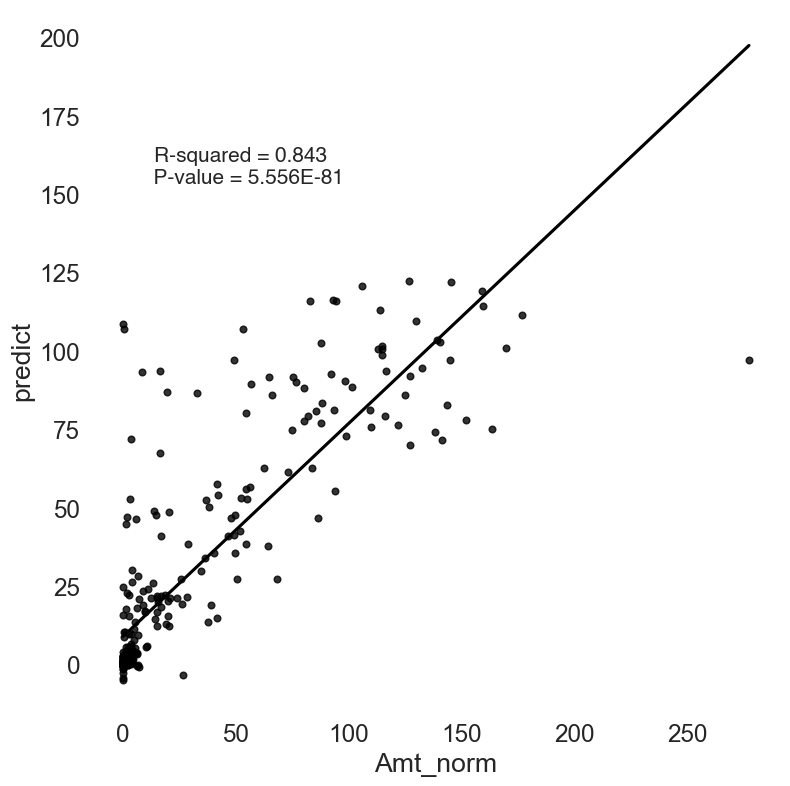

In [ ]:
correlation_plot(df3,"Amt_norm","predict")

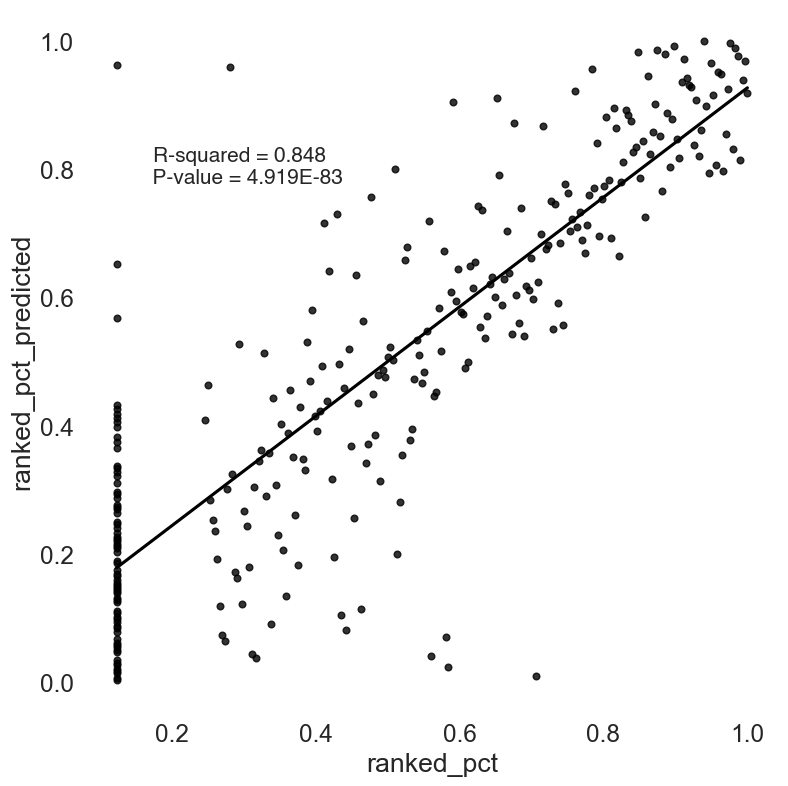

In [ ]:
correlation_plot(df3,"ranked_pct","ranked_pct_predicted")

### 4.3 Find predicted genotypes

In [ ]:
import numpy as np

In [ ]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/processed/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [ ]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,4
1,1,5,5
1,1,5,7
1,1,5,8
1,1,5,9
1,1,6,1
1,1,6,2
1,1,6,3


In [ ]:
#merge_ = pd.merge(new_input_for_ml,all_genotypes, on= ['0','1','2','3'])
#merge_
new_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/processed/input_for_ml_2nd_iteration.csv',  index_col=False)

input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
0,4,1,5,2
1,4,1,5,2
2,4,2,5,2
3,5,1,5,2
4,5,1,5,2
...,...,...,...,...
122,7,2,5,7
123,7,2,5,7
124,7,2,6,7
125,4,2,5,2


### 4.4 Getting rid of the genotypes we have already tested:

In [ ]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
#df_diff.to_csv('../data/processed/remaining_genotypes_after_first_iteration.csv')
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [ ]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
predicted = best_model.predict(all_genotypes_df)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [ ]:
len(predicted)

1049

In [ ]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,1.381696
1,0.937428
2,1.708319
3,1.602157
4,0.384537


In [ ]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_5141/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
614,5,2,6,8,125.507683
610,5,2,6,4,123.953873
748,6,2,6,2,121.058182
605,5,2,5,8,119.939774
602,5,2,5,4,119.415718
...,...,...,...,...,...
862,7,1,7,1,-5.890666
869,7,1,7,9,-6.474187
865,7,1,7,4,-6.538404
864,7,1,7,3,-6.681534


If we want the names on the genotypes we can do the following: 

In [ ]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

Save the data to a csv 

## 5. Top 20 predicted producers

In [ ]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(20)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cac,125.507683
1,Smus,ENO2,TPI1,Clo,123.953873
2,Rsep,ENO2,TPI1,Aan,121.058182
3,Smus,ENO2,CCW12,Cac,119.939774
4,Smus,ENO2,CCW12,Clo,119.415718
5,Smus,ENO2,CCW12,Aan,119.15493
6,Rsep,ENO2,TPI1,Cac,118.785843
7,Smus,ENO2,CCW12,Ara,113.73101
8,Rsep,ENO2,CCW12,Rse,113.126915
9,Rsep,ENO2,CCW12,Cac,111.33947


In [ ]:
df_with_genotypes.to_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics_1.csv')

In [ ]:
df_with_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics_1.csv', index_col=False)
df_with_genotypes

,Unnamed: 0,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,0,Smus,ENO2,TPI1,Cac,125.507683
1,1,Smus,ENO2,TPI1,Clo,123.953873
2,2,Rsep,ENO2,TPI1,Aan,121.058182
3,3,Smus,ENO2,CCW12,Cac,119.939774
4,4,Smus,ENO2,CCW12,Clo,119.415718
...,...,...,...,...,...,...
1044,1044,Oeu,CYC1,MLS1,Cro,-5.890666
1045,1045,Oeu,CYC1,MLS1,Oeu,-6.474187
1046,1046,Oeu,CYC1,MLS1,Clo,-6.538404
1047,1047,Oeu,CYC1,MLS1,Ara,-6.681534


In [ ]:
from constrain.plotting.plotting import bar_plot
bar_plot

<function constrain.plotting.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, path='') -> None>

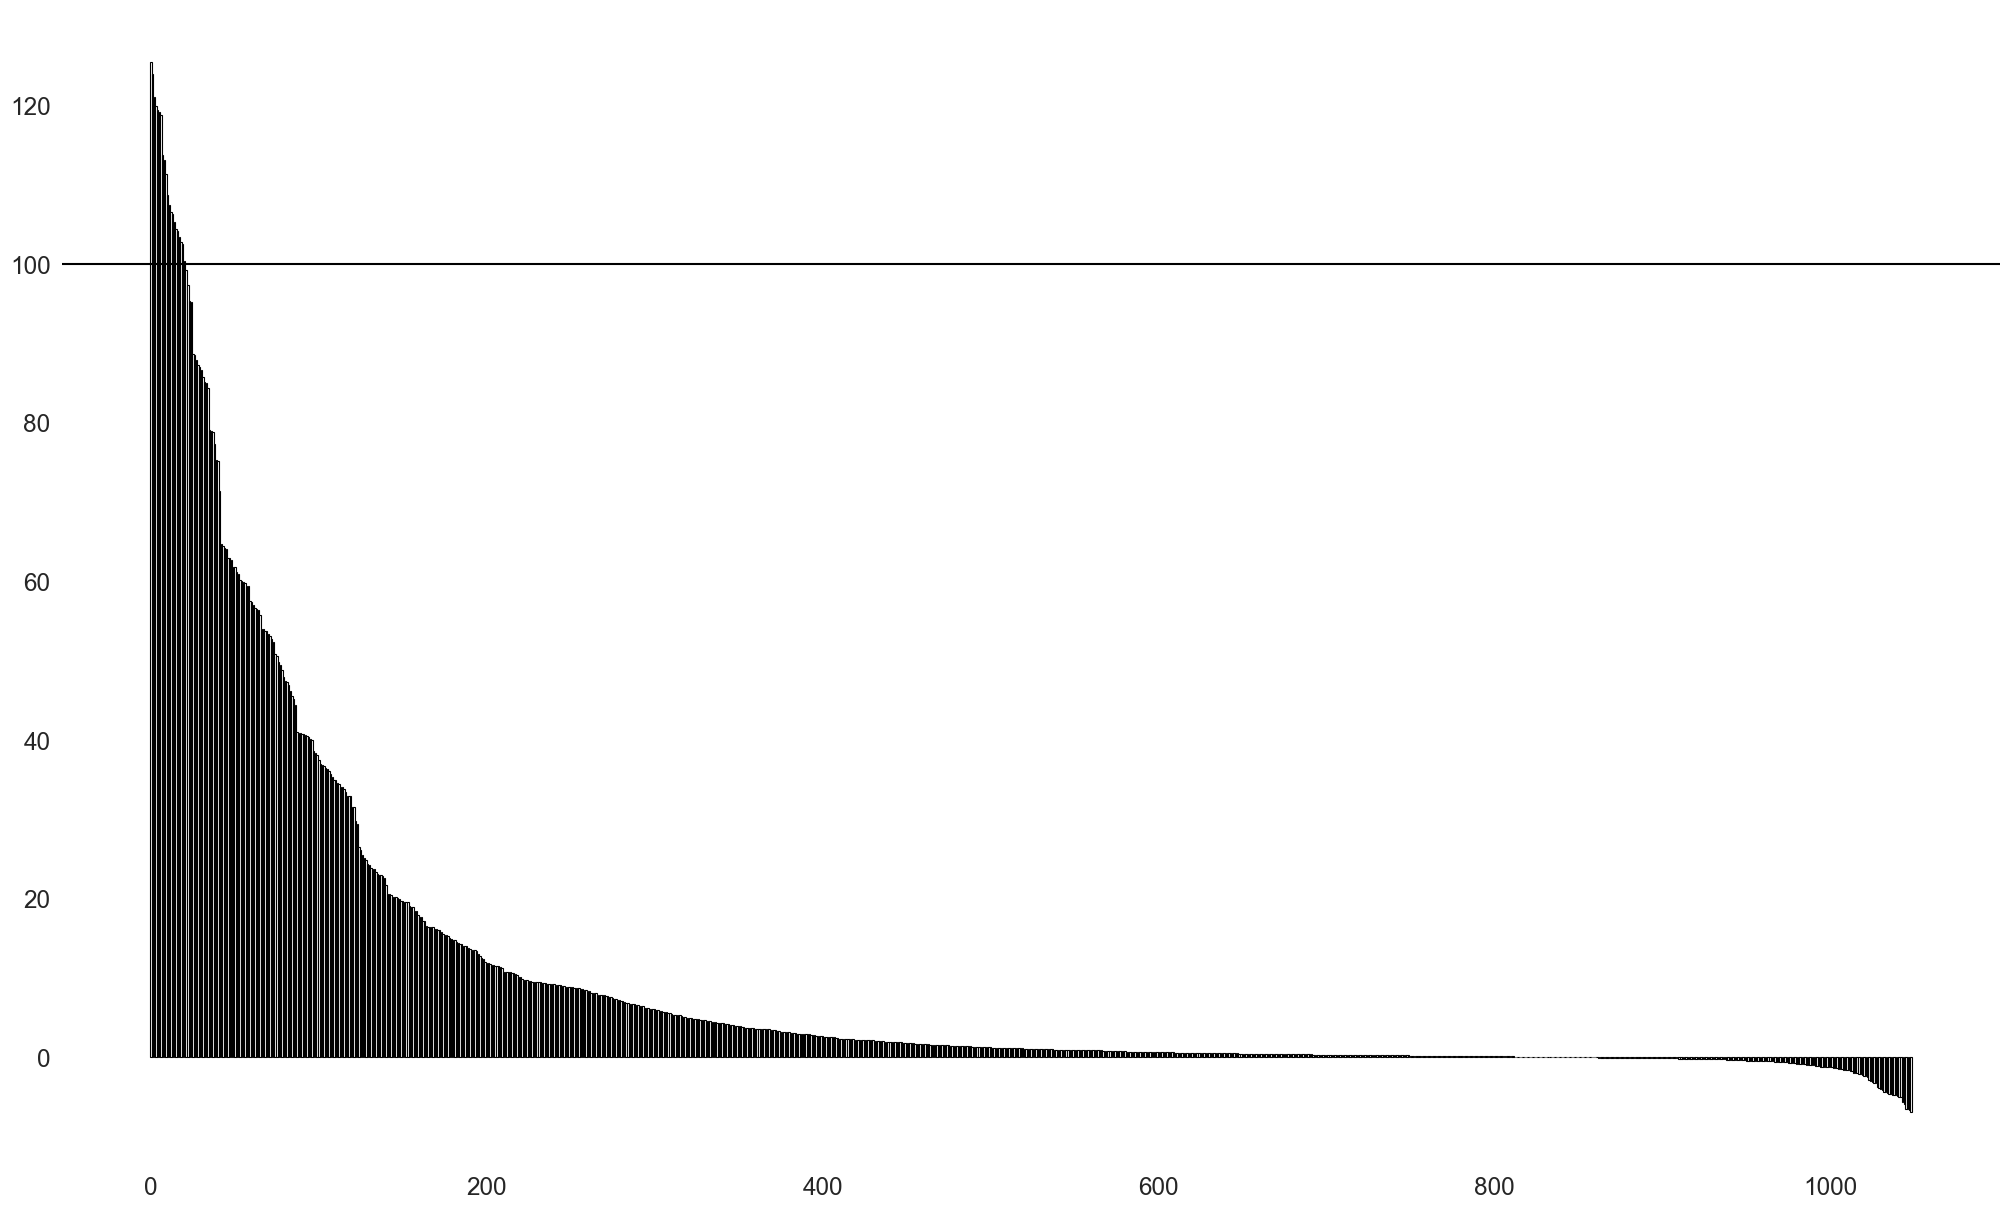

In [ ]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y)

In [ ]:
df_with_genotypes.to_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics.csv', index=False)

In [ ]:
df_with_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_2nd_analytics.csv')

In [ ]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [ ]:
df_with_genotypes

,Unnamed: 0,G8H,pG8H,pCPR,CPR,Predicted_strict_production,names
0,0,Smus,ENO2,TPI1,Cac,125.507683,Smus-ENO2_TPI1_Cac
1,1,Smus,ENO2,TPI1,Clo,123.953873,Smus-ENO2_TPI1_Clo
2,2,Rsep,ENO2,TPI1,Aan,121.058182,Rsep-ENO2_TPI1_Aan
3,3,Smus,ENO2,CCW12,Cac,119.939774,Smus-ENO2_CCW12_Cac
4,4,Smus,ENO2,CCW12,Clo,119.415718,Smus-ENO2_CCW12_Clo
...,...,...,...,...,...,...,...
1044,1044,Oeu,CYC1,MLS1,Cro,-5.890666,Oeu-CYC1_MLS1_Cro
1045,1045,Oeu,CYC1,MLS1,Oeu,-6.474187,Oeu-CYC1_MLS1_Oeu
1046,1046,Oeu,CYC1,MLS1,Clo,-6.538404,Oeu-CYC1_MLS1_Clo
1047,1047,Oeu,CYC1,MLS1,Ara,-6.681534,Oeu-CYC1_MLS1_Ara


In [ ]:
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

In [ ]:
from constrain.plotting.plotting import horisontal_bar_plot

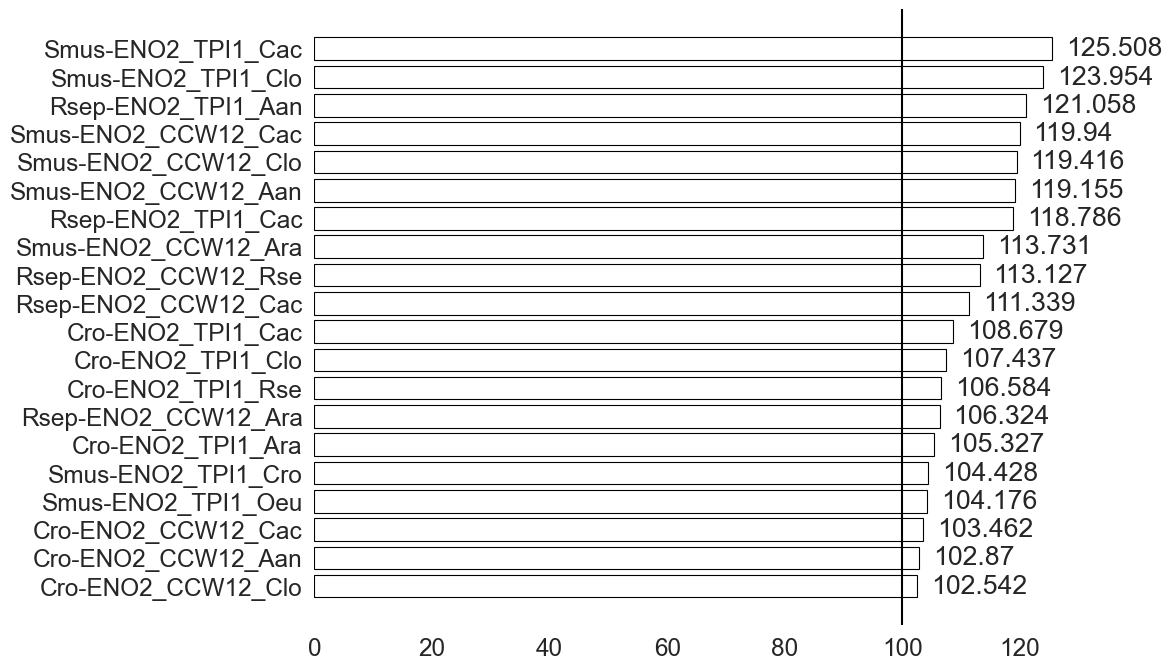

In [ ]:
horisontal_bar_plot(x_axis,y_axis)

### 5.1 How many genotypes are predicted to produce more than the control strain?

In [ ]:
over_100_strict_procduction = df_with_genotypes[df_with_genotypes['Predicted_strict_production'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(df_with_genotypes)} showed production of strictosidine over the normalized value")
print(f"Out of the remaing theoretical space these constittue : {(len(over_100_strict_procduction)/len(df_with_genotypes))*100}")

## 6. Learning curve on data

In [ ]:
from constrain.machine_learning.auto_ml import autoML_on_partitioned_data

In [ ]:
new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_A01,1,2,5,1,0.972701
1,yp49_C01,1,2,5,9,0.536658
2,yp49_D01,2,4,7,3,0.175896
3,yp49_E01,2,1,5,7,0.345201
4,yp49_F01,3,3,6,1,26.416324
...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,15.322951
125,yp54_C04,5,2,6,3,94.318358
126,yp54_C09,3,1,6,3,46.469517
127,yp54_D12,5,1,6,6,3.718051


In [ ]:
%%capture
feature_cols = ['0', '1', '2', '3']
training_column = 'Amt_norm'
#autoML_on_partitioned_data(feature_cols, training_column,new_input_for_ml,training_time=0, partitions = 5,  path = 'ConStrain_on_google_colab/Data/AutoML/testing_partitioning_second_round/')

#for i in range(0,1): 
#    autoML_on_partitioned_data(feature_cols, training_column,new_input_for_ml,training_time=0, partitions = 5,  path = 'ConStrain_on_google_colab/Data/AutoML/testing_partitioning_second_round/')

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_a5a3a0b4bda38851dd0a15fa536d4229> was cancelled by the user.

In [ ]:
import os

# folder path
dir_path = 'ConStrain_on_google_colab/Data/AutoML/testing_partitioning_second_round/'

# list file and directories
res = os.listdir(dir_path)
res

['2022_12_15_14:08_ml_models_running_over_partioned_data.csv',
 '.ipynb_checkpoints']

In [ ]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [ ]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes]
concated = pd.concat(dfs, axis=1)
concated

,0,CV_mean_MAE,CV_SD_MAE,Model_name
Unnamed: 0,,,,
60,2.244198,4.716780,3.499275,DeepLearning_grid_3_AutoML_2_20221215_91100_model_1
120,5.179617,11.684734,7.085234,XGBoost_lr_search_selection_AutoML_4_20221215_101122_select_grid_m...
180,4.993560,9.641539,4.611245,XGBoost_grid_1_AutoML_5_20221215_111040_model_1104
240,6.969398,14.219012,4.691857,XGBoost_lr_search_selection_AutoML_6_20221215_121030_select_grid_m...
296,11.253236,14.659073,3.082144,StackedEnsemble_AllModels_5_AutoML_7_20221215_130921


In [ ]:

# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1271/2914699888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['mean'] = test_results.mean(axis=1)
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1271/2914699888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['std'] = test_results.std(axis=1)


,0,mean,std
Unnamed: 0,,,
60,2.244198,2.244198,0.0
120,5.179617,5.179617,0.0
180,4.993560,4.993560,0.0
240,6.969398,6.969398,0.0
296,11.253236,11.253236,0.0


In [ ]:

# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1271/1005275068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results['mean'] = cross_validated_results.mean(axis=1)


,CV_mean_MAE,mean
Unnamed: 0,,
60,4.716780,4.716780
120,11.684734,11.684734
180,9.641539,9.641539
240,14.219012,14.219012
296,14.659073,14.659073


In [ ]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1271/3504483626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)


,CV_SD_MAE,mean
Unnamed: 0,,
60,3.499275,3.499275
120,7.085234,7.085234
180,4.611245,4.611245
240,4.691857,4.691857
296,3.082144,3.082144


In [ ]:
from constrain.plotting.plotting import plot_ml_learning_curve

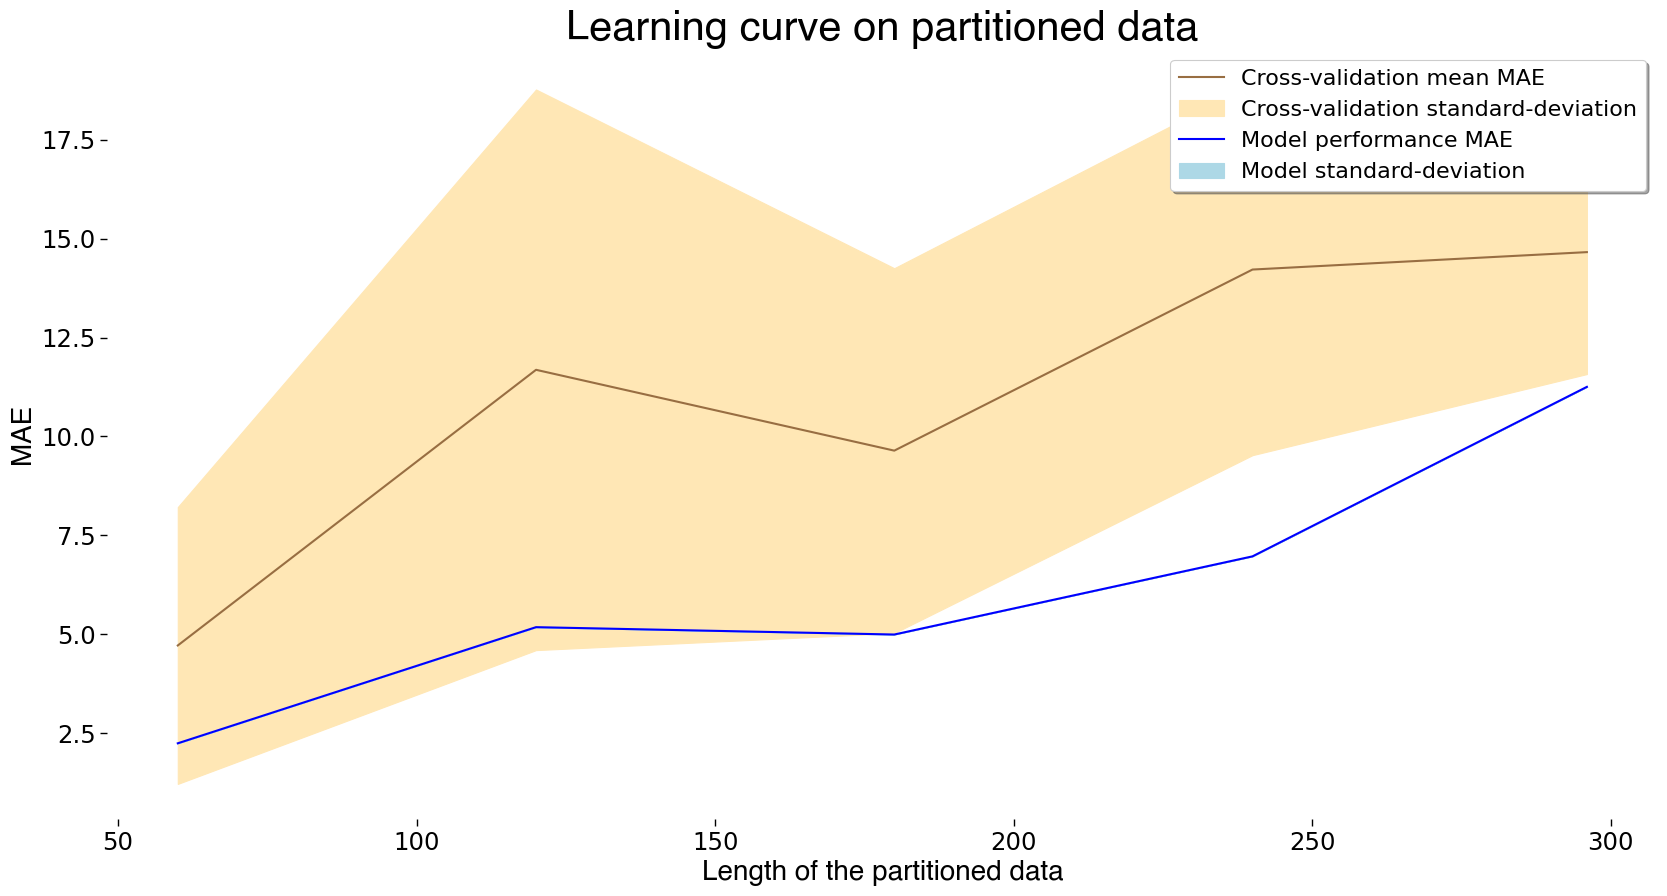

In [ ]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  np.array(list(cross_validated_results_sd['mean']))

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))


plot = plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True , path = 'ConStrain_on_google_colab/Data/Plots_for_publication/11_2_LEARN_Data_analysis/Learning_curve_on_partitioned_data_DBTL2')

In [ ]:
#### How many of the predictions d

In [ ]:
h2o.shutdown()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_5141/2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


H2O session _sid_959e closed.
